Epoch 1/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 38s 41ms/step - accuracy: 0.2521 - loss: 1.9845 - val_accuracy: 0.4064 - val_loss: 1.6576 - learning_rate: 0.0010
Epoch 2/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 30s 38ms/step - accuracy: 0.4324 - loss: 1.5594 - val_accuracy: 0.4298 - val_loss: 1.6290 - learning_rate: 0.0010
Epoch 3/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - accuracy: 0.4947 - loss: 1.4063 - val_accuracy: 0.5160 - val_loss: 1.3425 - learning_rate: 0.0010
Epoch 4/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - accuracy: 0.5327 - loss: 1.2995 - val_accuracy: 0.5429 - val_loss: 1.2727 - learning_rate: 0.0010
Epoch 5/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - accuracy: 0.5662 - loss: 1.2242 - val_accuracy: 0.5723 - val_loss: 1.2070 - learning_rate: 0.0010
Epoch 6/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - accuracy: 0.5809 - loss: 1.1786 - val_accuracy: 0.5894 - val_loss: 1.1875 - learning_rate: 0.0010
Epoch 7/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 30s 38ms/step - accuracy: 0.6

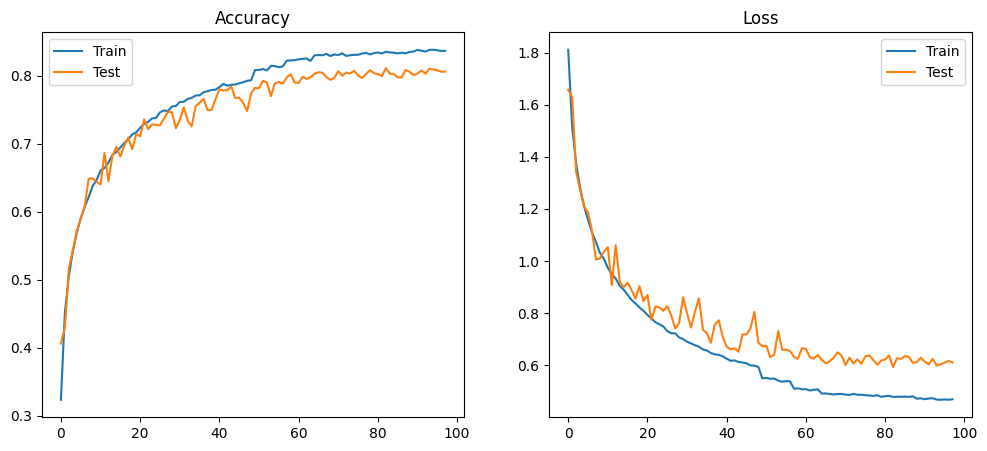

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
)
datagen.fit(x_train)

# Model architecture
from tensorflow.keras import layers, models, Input

def build_model():
    inputs = Input(shape=(32, 32, 3))

    # === Block 1 (24 filters with residual connection) ===
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    # Residual connection: input -> block output
    shortcut1 = layers.Conv2D(32, (1, 1), padding='same')(inputs)
    x = layers.Add()([x, shortcut1])
    x = layers.MaxPooling2D(pool_size=2)(x)

    # === Block 2 (48 filters with residual connection) ===
    block2_input = x  # store block input for proper residual
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(block2_input)
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    # Residual connection: block input -> block output
    shortcut2 = layers.Conv2D(64, (1, 1), padding='same')(block2_input)
    x = layers.Add()([x, shortcut2])
    x = layers.MaxPooling2D(pool_size=2)(x)

    # === Global Average Pooling ===
    x = layers.GlobalAveragePooling2D()(x)

    # === Output ===
    outputs = layers.Dense(10, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

model = build_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=5, factor=0.5, verbose=1)
early_stop = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)

# Train
history = model.fit(datagen.flow(x_train, y_train, batch_size=64),
                    validation_data=(x_test, y_test),
                    epochs=100,
                    callbacks=[lr_reduction, early_stop],
                    verbose=1)

# Evaluate
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Plotting
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Test')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.title('Loss')
plt.legend()
plt.show()

In [3]:
model.save('model.keras')

In [4]:
from google.colab import files
files.download("model.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>